In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing Libraries

In [3]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [4]:
train_dir = '/content/drive/MyDrive/Brain Tumor Project/Training'
test_dir = '/content/drive/MyDrive/Brain Tumor Project/Testing'


train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

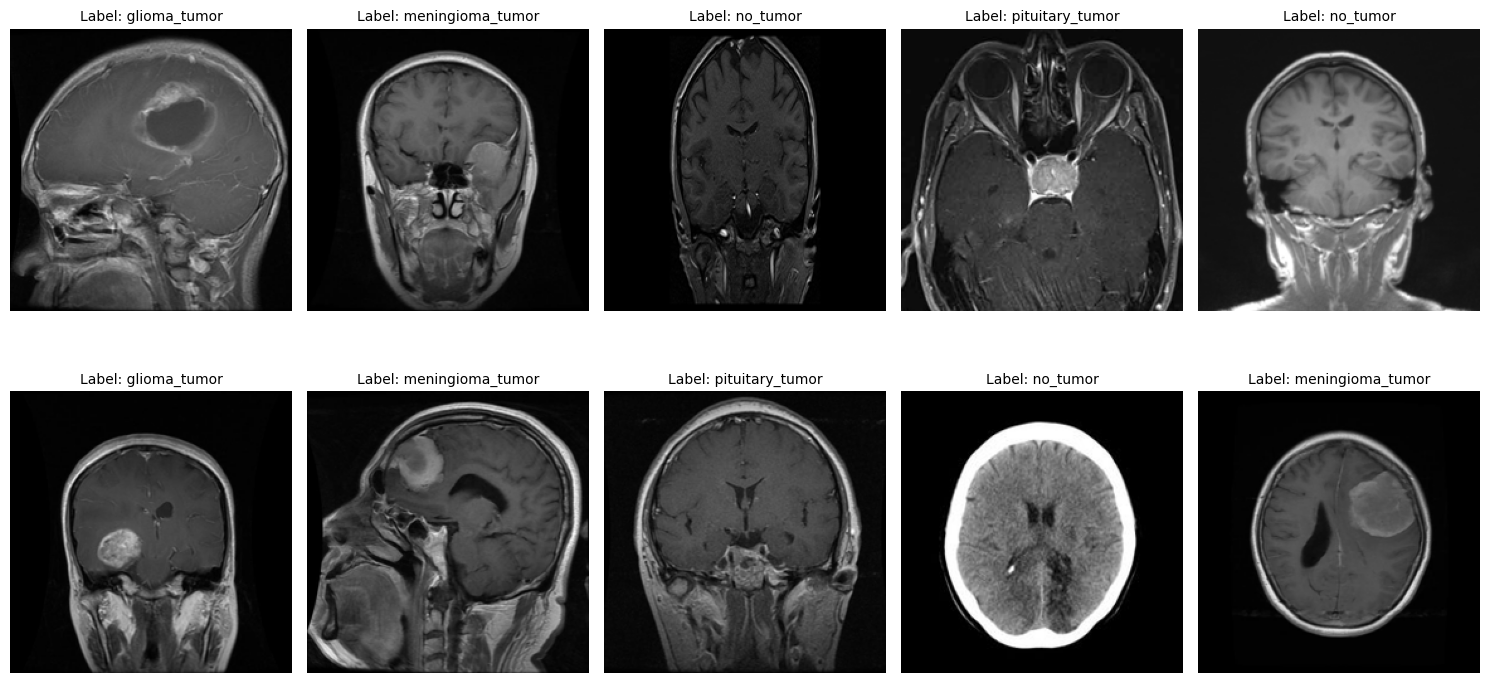

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

random_indices = random.sample(range(len(train_paths)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

# Image Augmentation function

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

# Loading images and apply augmentation

In [7]:
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)

In [8]:
def encode_label(labels):
    unique_labels = os.listdir(train_dir)
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching

In [9]:
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# Model architecture

In [10]:
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Freeze all layers of the VGG16 base model

In [11]:
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable

In [12]:
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Building the final model

In [13]:
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

# Compiling the model

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters

In [15]:
batch_size = 32
steps = int(len(train_paths) / batch_size)
epochs = 19

# Training the model

In [16]:
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),epochs=epochs, steps_per_epoch=steps)

Epoch 1/19
89/89 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - loss: 1.0532 - sparse_categorical_accuracy: 0.5499
Epoch 2/19
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - loss: 0.4234 - sparse_categorical_accuracy: 0.8362
Epoch 3/19
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - loss: 0.2829 - sparse_categorical_accuracy: 0.8900
Epoch 4/19
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - loss: 0.1726 - sparse_categorical_accuracy: 0.9310
Epoch 5/19
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - loss: 0.1287 - sparse_categorical_accuracy: 0.9511
Epoch 6/19
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 192ms/step - loss: 0.0817 - sparse_categorical_accuracy: 0.9701
Epoch 7/19
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9608
Epoch 8/19
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - loss: 0.1146 - sparse_categorical_accuracy: 0.9542
Epoch 9/19
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 0.0985 - sparse_categorical_accuracy: 0.9622
Epoch 10/19
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms

#Training Vs Val Plot

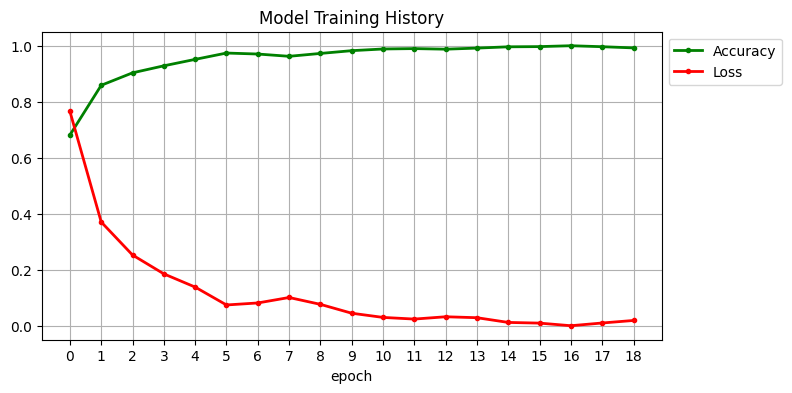

In [17]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#Model Classification Report

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)
test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.66      0.80        74
           1       0.70      0.98      0.82       115
           2       0.69      1.00      0.82       105
           3       0.87      0.27      0.41       100

    accuracy                           0.75       394
   macro avg       0.81      0.73      0.71       394
weighted avg       0.80      0.75      0.71       394



##Confusion Matrix

In [19]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 49   9  13   3]
 [  0 113   1   1]
 [  0   0 105   0]
 [  0  40  33  27]]


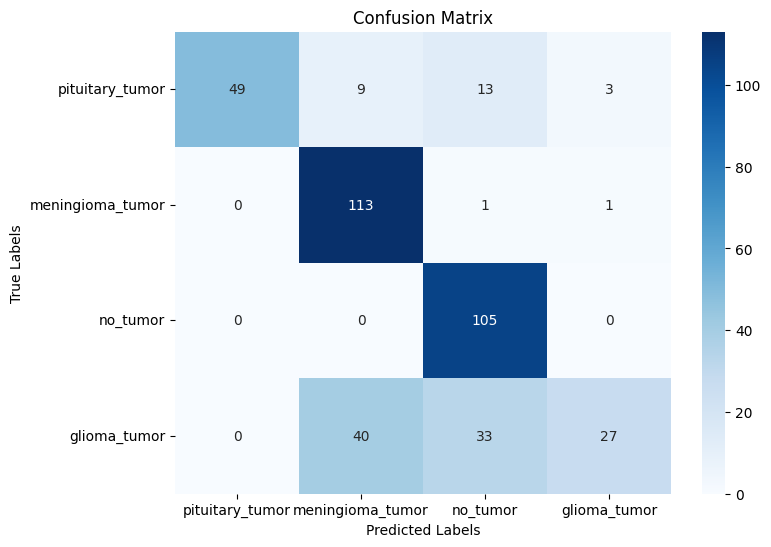

In [20]:

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

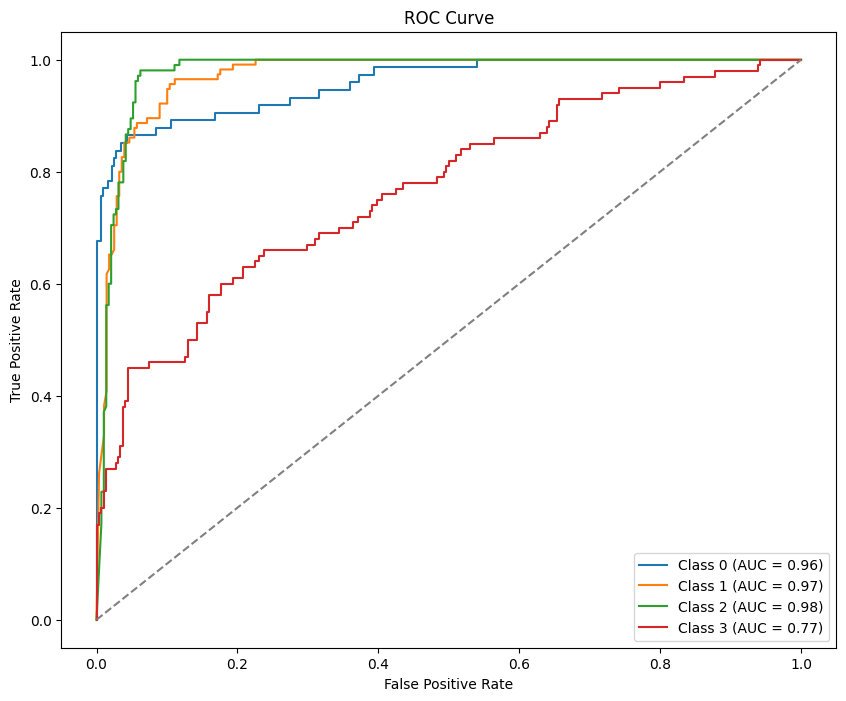

In [21]:
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [22]:
model.save('model_by_dawood.h5')

In [23]:
from tensorflow.keras.models import load_model
model = load_model('model_by_dawood.h5')

In [24]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)


        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"


        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


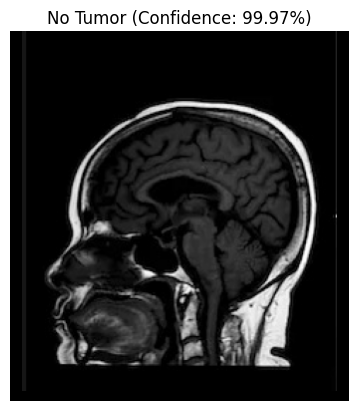

In [25]:
# Example usage
image_path = '/content/drive/MyDrive/Brain Tumor Project/download (1).png'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


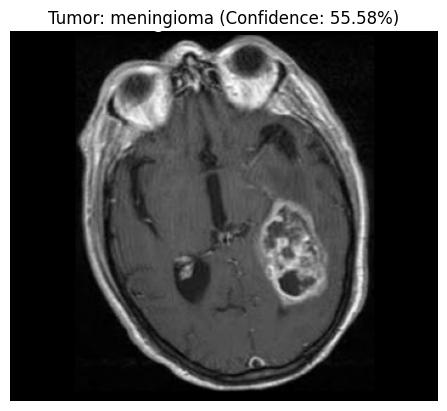

In [31]:
# Example usage
image_path = '/content/drive/MyDrive/Brain Tumor Project/download.png'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


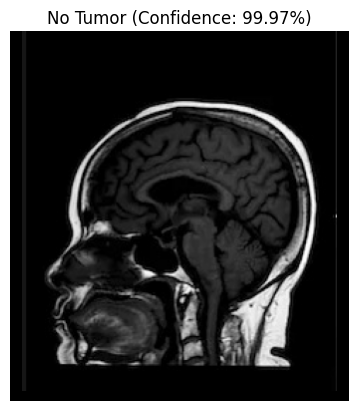

In [32]:
# Example usage
image_path = '/content/drive/MyDrive/Brain Tumor Project/download (1).png'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


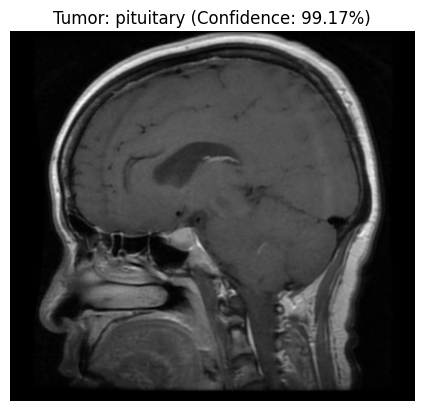

In [33]:
# Example usage
image_path = '/content/drive/MyDrive/Brain Tumor Project/download (2).png'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


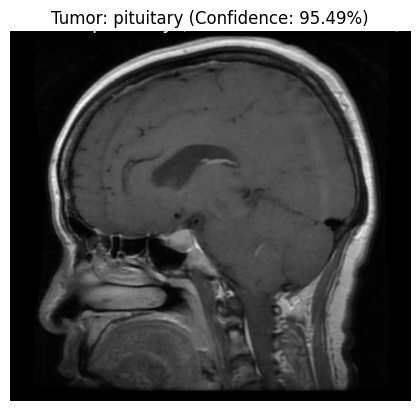

In [34]:
# Example usage
image_path = '/content/drive/MyDrive/Brain Tumor Project/download (3).png'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


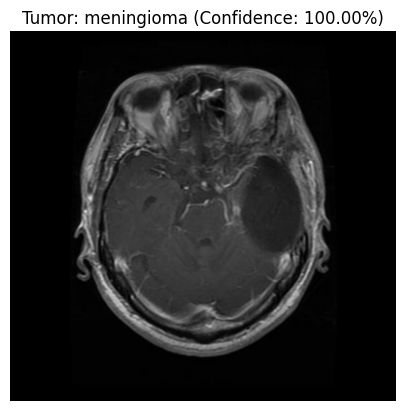

In [35]:
# Example usage
image_path = '/content/drive/MyDrive/Brain Tumor Project/download (4).png'
detect_and_display(image_path, model)